In [1]:
# pip install missingno

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statistics as stat

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.datasets import make_classification

import joblib
import xgboost as xgb
from xgboost import XGBClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from collections import Counter
from matplotlib import pyplot
from numpy import where
from imblearn.over_sampling import ADASYN

In [3]:
pd.options.display.max_rows = 4000

### Importing the data

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.shape

(7500, 18)

In [6]:
test.shape

(2500, 17)

In [7]:
train.columns

Index(['Id', 'Home Ownership', 'Annual Income', 'Years in current job',
       'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [8]:
test.columns

Index(['Id', 'Home Ownership', 'Annual Income', 'Years in current job',
       'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'],
      dtype='object')

In [9]:
data = pd.concat([train,test])

### Data Overview

In [10]:
pd.set_option("display.max_columns", 150)
data.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            10000 non-null  int64  
 1   Home Ownership                10000 non-null  object 
 2   Annual Income                 7930 non-null   float64
 3   Years in current job          9543 non-null   object 
 4   Tax Liens                     10000 non-null  float64
 5   Number of Open Accounts       10000 non-null  float64
 6   Years of Credit History       10000 non-null  float64
 7   Maximum Open Credit           10000 non-null  float64
 8   Number of Credit Problems     10000 non-null  float64
 9   Months since last delinquent  4561 non-null   float64
 10  Bankruptcies                  9983 non-null   float64
 11  Purpose                       10000 non-null  object 
 12  Term                          10000 non-null  object 
 13  Cu

In [12]:
# replace '<' for xgb algorithm
data.replace(['<'],'less than', regex=True, inplace=True)

In [13]:
data['Years in current job'].value_counts().reset_index()

,index,Years in current job
0,10+ years,3142
1,2 years,917
2,3 years,848
3,less than 1 year,770
4,5 years,685
5,1 year,657
6,4 years,621
7,6 years,563
8,7 years,536
9,8 years,446


In [14]:
data.isnull().sum()

Id                                 0
Home Ownership                     0
Annual Income                   2070
Years in current job             457
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    5439
Bankruptcies                      17
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
Credit Default                  2500
dtype: int64

In [15]:
# List the numeric columns
num = [col for col in data.columns if data[col].dtype != 'object']
print(num)

['Id', 'Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Default']


In [16]:
# List the categorical columns
obj = [col for col in data.columns if data[col].dtype == 'object']
print(obj)

['Home Ownership', 'Years in current job', 'Purpose', 'Term']


In [17]:
# List the unique values in each numeric column 
pd.Series({col: data[col].unique() for col in data[num].columns})

Id                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Annual Income                   [482087.0, 1025487.0, 751412.0, 805068.0, 7762...
Tax Liens                          [0.0, 3.0, 1.0, 2.0, 4.0, 6.0, 5.0, 7.0, 15.0]
Number of Open Accounts         [11.0, 15.0, 8.0, 13.0, 12.0, 9.0, 17.0, 10.0,...
Years of Credit History         [26.3, 15.3, 35.0, 22.5, 13.6, 14.6, 20.3, 12....
Maximum Open Credit             [685960.0, 1181730.0, 1182434.0, 147400.0, 385...
Number of Credit Problems          [1.0, 0.0, 3.0, 2.0, 6.0, 4.0, 5.0, 7.0, 15.0]
Months since last delinquent    [nan, 73.0, 18.0, 6.0, 40.0, 44.0, 45.0, 17.0,...
Bankruptcies                                  [1.0, 0.0, 3.0, nan, 2.0, 4.0, 5.0]
Current Loan Amount             [99999999.0, 264968.0, 121396.0, 125840.0, 337...
Current Credit Balance          [47386.0, 394972.0, 308389.0, 95855.0, 93309.0...
Monthly Debt                    [7914.0, 18373.0, 13651.0, 11338.0, 7180.0, 18...
Credit Score    

In [18]:
# List the unique values in each categorical column
pd.Series({col: data[col].unique() for col in data[obj].columns})

Home Ownership             [Own Home, Home Mortgage, Rent, Have Mortgage]
Years in current job    [nan, 10+ years, 8 years, 6 years, 7 years, 5 ...
Purpose                 [debt consolidation, other, home improvements,...
Term                                              [Short Term, Long Term]
dtype: object

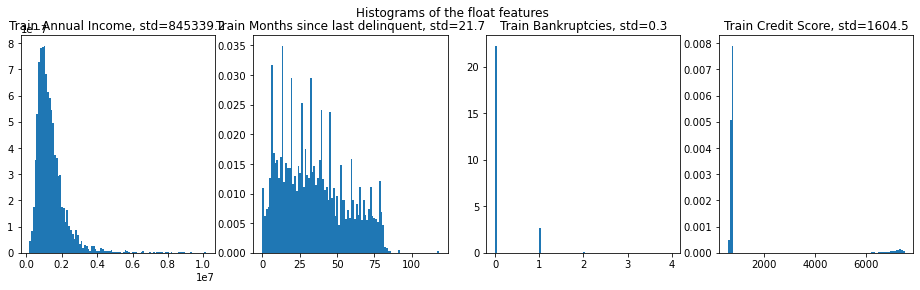

In [19]:
# histograms of num columns 
missing = ['Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for f, ax in zip(missing, axs.ravel()):
    ax.hist(train[f], density=True, bins=100)
    ax.set_title(f'Train {f}, std={train[f].std():.1f}')
plt.suptitle('Histograms of the float features')
plt.show()

In [20]:
data['Bankruptcies'].value_counts()

0.0    8912
1.0    1020
2.0      36
3.0      10
4.0       3
5.0       2
Name: Bankruptcies, dtype: int64

In [21]:
data_credit_score = data.groupby(['Credit Score'])['Id'].count().sort_values(ascending=False).reset_index()
data_credit_score.head()

,Credit Score,Id
0,740.0,219
1,747.0,217
2,741.0,205
3,748.0,201
4,746.0,201


In [22]:
null_perc = data.isna().sum()/data.shape[0]
null_perc

Id                              0.0000
Home Ownership                  0.0000
Annual Income                   0.2070
Years in current job            0.0457
Tax Liens                       0.0000
Number of Open Accounts         0.0000
Years of Credit History         0.0000
Maximum Open Credit             0.0000
Number of Credit Problems       0.0000
Months since last delinquent    0.5439
Bankruptcies                    0.0017
Purpose                         0.0000
Term                            0.0000
Current Loan Amount             0.0000
Current Credit Balance          0.0000
Monthly Debt                    0.0000
Credit Score                    0.2070
Credit Default                  0.2500
dtype: float64

In [23]:
data.shape

(10000, 18)

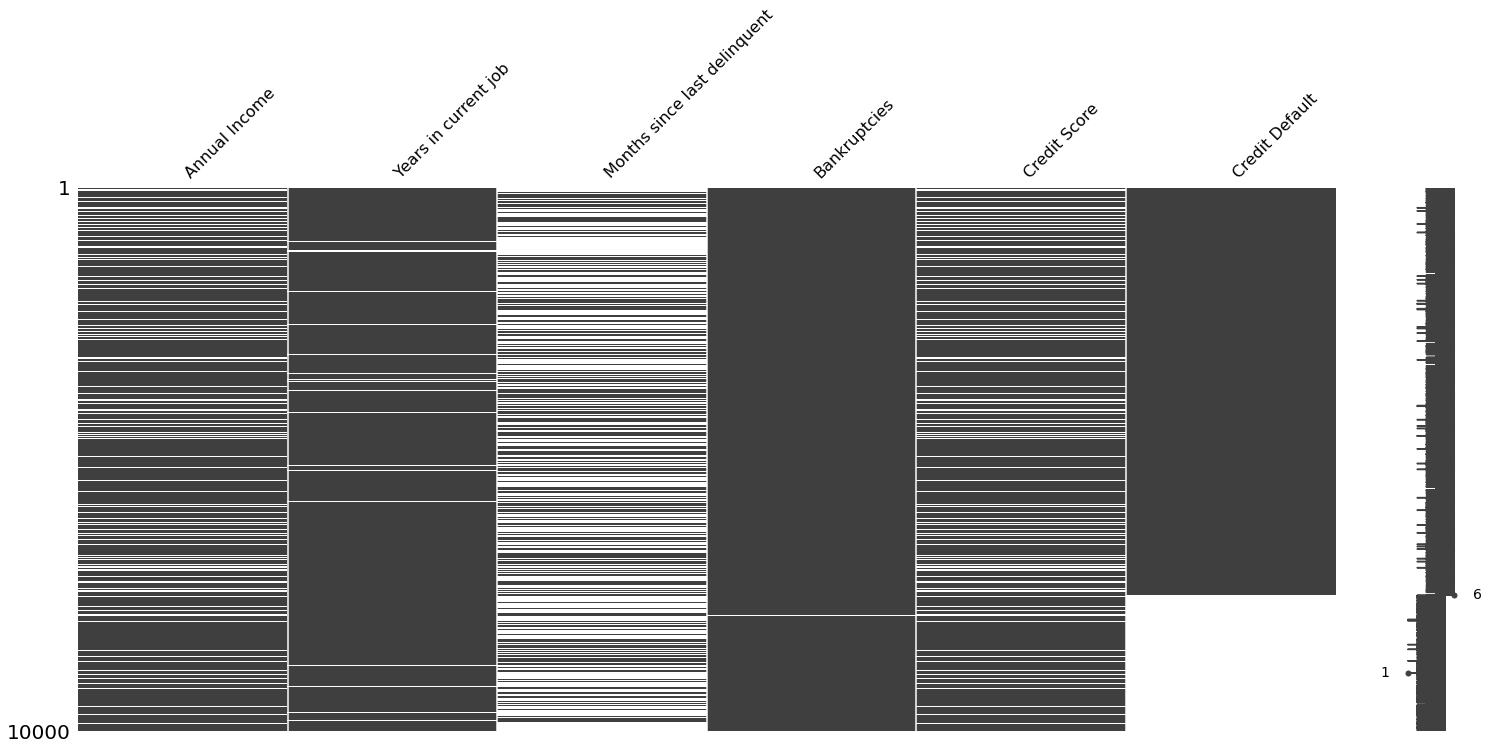

In [24]:
missingdata_data = data.columns[data.isnull().any()].tolist()
msno.matrix(data[missingdata_data])

In [25]:
num = [col for col in data.columns if data[col].dtype != 'object' and col != 'Credit Default']
obj = [col for col in data.columns if data[col].dtype == 'object']

In [26]:
data['Bankruptcies'].fillna(0, inplace=True)
data['Months since last delinquent'].fillna(0, inplace=True)

In [27]:
data['Credit Score'].fillna(data['Credit Score'].median(), inplace = True)

In [28]:
mice_impute = IterativeImputer(min_value=0)
data[num] = mice_impute.fit_transform(data[num])

In [29]:
# Use fillna to impute null values with mode in categorical columns 
l = data[obj].mode()
data[obj] = data[obj].fillna(value=l.iloc[0])

# can try KNN imputer next time

In [30]:
data.isnull().sum()

Id                                 0
Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                  2500
dtype: int64

In [31]:
# All features 
data_num = list(data.select_dtypes(include = np.number).columns)
data_obj = list(data.select_dtypes(include = np.object).columns) 

In [32]:
data_num

['Id',
 'Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [33]:
data_obj

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [34]:
dum = pd.get_dummies(data[data_obj], drop_first=True)

In [35]:
data_mod = pd.concat([data[data_num], dum], axis = 1)

In [36]:
data_mod.shape

(10000, 42)

In [37]:
data_mod.tail()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_less than 1 year,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Short Term
2495,9995.0,1.020053e+06,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,99999999.0,162735.0,15046.0,745.0,NaN,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2496,9996.0,2.253885e+06,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,468512.0,1439269.0,32996.0,731.0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2497,9997.0,1.171806e+06,0.0,48.0,12.8,1706430.0,0.0,0.0,0.0,430496.0,676438.0,36912.0,695.0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2498,9998.0,7.235200e+05,0.0,14.0,28.8,945780.0,0.0,0.0,0.0,257774.0,391248.0,13506.0,744.0,NaN,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2499,9999.0,1.694439e+06,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,763004.0,559531.0,23440.0,6820.0,NaN,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
data_mod_train = data_mod[data_mod['Credit Default'].notnull()]
data_mod_test = data_mod[data_mod['Credit Default'].isnull()]

print(data_mod_train.shape)
print(data_mod_test.shape)

(7500, 42)
(2500, 42)


In [39]:
x = data_mod_train.drop(['Id','Credit Default'], axis = 1)
y = data_mod_train['Credit Default']

In [40]:
x_train, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size = 0.3, random_state = 10)

In [41]:
print(f'{round(sum(y==1)/y.count()*100,3)} % is positive for target variable')

28.173 % is positive for target variable


### Scaling

In [42]:
from sklearn.preprocessing import StandardScaler
Scaler_x = StandardScaler()
x_train = Scaler_x.fit_transform(x_train)
x_val = Scaler_x.transform(x_val)

# Model Building

In [43]:
# Result Collection List
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()
accuracy = list()

In [44]:
# Function for appending data into corresponding list
def test_eval(clf_model, x_val, y_val, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(x_val)
    y_pred=clf_model.predict(x_val)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_val,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_val,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_val, y_prob[:,1]))
          
    model.append(algo)
    accuracy.append(accuracy_score(y_val,y_pred))
    precision.append(precision_score(y_val,y_pred))
    recall.append(recall_score(y_val,y_pred))
    F1score.append(f1_score(y_val,y_pred))
    AUCROC.append(roc_auc_score(y_val, y_prob[:,1]))
    resample.append(sampling)

In [45]:
# 10-fold Cross validation object
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

## Logistic Regression

In [207]:
log_model=LogisticRegression(random_state=42)

params={'C':np.logspace(-10, 1, 15),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

# Create grid search using 10-fold cross validation
clf_LR = GridSearchCV(log_model, params, cv=cv, scoring='roc_auc', n_jobs=-1)
clf_LR.fit(x_train, y_train)
clf_LR.best_estimator_

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10.0, random_state=42)

In [208]:
test_eval(clf_LR, x_val, y_val, 'Logistic Regression', 'Actual')

Confusion Matrix
[[1575   41]
 [ 462  172]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86      1616
         1.0       0.81      0.27      0.41       634

    accuracy                           0.78      2250
   macro avg       0.79      0.62      0.63      2250
weighted avg       0.78      0.78      0.73      2250
 

AUC-ROC
0.7563520941999562


## Decision Tree

In [209]:
estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

In [210]:
tree_model = DecisionTreeClassifier(random_state=42)

tree_param_grid = { 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2, random_state=42)
clf_DT.fit(x_train, y_train)
clf_DT.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=50,
                       random_state=42)

In [211]:
test_eval(clf_DT, x_val, y_val, 'Decision Tree', 'Actual')

Confusion Matrix
[[1546   70]
 [ 441  193]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86      1616
         1.0       0.73      0.30      0.43       634

    accuracy                           0.77      2250
   macro avg       0.76      0.63      0.64      2250
weighted avg       0.77      0.77      0.74      2250
 

AUC-ROC
0.7409745213480339


## Random Forest

In [212]:
rf_model = RandomForestClassifier(random_state=42)

rf_params={'n_estimators':estimators,
           'max_depth':max_depth,
           'min_samples_split':min_samples_split}

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1, n_iter=20, verbose=2, random_state=42)
clf_RF.fit(x_train, y_train)
clf_RF.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.8s finished


RandomForestClassifier(max_depth=9, min_samples_split=10, random_state=42)

In [213]:
test_eval(clf_RF, x_val, y_val, 'Random Forest', 'Actual')

Confusion Matrix
[[1614    2]
 [ 508  126]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      1616
         1.0       0.98      0.20      0.33       634

    accuracy                           0.77      2250
   macro avg       0.87      0.60      0.60      2250
weighted avg       0.82      0.77      0.71      2250
 

AUC-ROC
0.7624064949870382


## XGBoost

In [214]:
classifier_XGB = XGBClassifier(random_state=42)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

clf_XGB = RandomizedSearchCV(classifier_XGB, param_distributions=params, n_iter=20, scoring='roc_auc', 
                                   n_jobs=-1, cv=cv, verbose=2, random_state=42)
clf_XGB.fit(x_train, y_train)
clf_XGB.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   50.8s finished
C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [215]:
test_eval(clf_XGB, x_val, y_val, 'XGBoost', 'Actual')

Confusion Matrix
[[1555   61]
 [ 447  187]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86      1616
         1.0       0.75      0.29      0.42       634

    accuracy                           0.77      2250
   macro avg       0.77      0.63      0.64      2250
weighted avg       0.77      0.77      0.74      2250
 

AUC-ROC
0.7633166559952524


## LightGBM

In [216]:
classifier_LGBM = LGBMClassifier(random_state=42)

params = {
        'n_estimators': [400, 700, 1000, 5000],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'max_depth': [15,20,25],
        'num_leaves': [50, 100, 200, 500, 1000],
        'reg_alpha': [1.0, 1.1, 1.2],
        'reg_lambda': [1.0, 1.1, 1.2],
        'min_split_gain': [0.2, 0.3, 0.4],
        'subsample': [0.7, 0.8, 0.9],
        'subsample_freq': [20, 30, 40]
        }

clf_LGBM = RandomizedSearchCV(classifier_LGBM, param_distributions=params, n_iter=20, scoring='roc_auc', 
                                   n_jobs=-1, cv=cv, verbose=2, random_state=42)
clf_LGBM.fit(x_train, y_train)
clf_LGBM.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


LGBMClassifier(max_depth=20, min_split_gain=0.3, n_estimators=5000,
               num_leaves=1000, random_state=42, reg_alpha=1.0, reg_lambda=1.1,
               subsample=0.9, subsample_freq=20)

In [217]:
test_eval(clf_LGBM, x_val, y_val, 'LGBM', 'Actual')

Confusion Matrix
[[1493  123]
 [ 402  232]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      1616
         1.0       0.65      0.37      0.47       634

    accuracy                           0.77      2250
   macro avg       0.72      0.64      0.66      2250
weighted avg       0.75      0.77      0.74      2250
 

AUC-ROC
0.7534815488646657


## CatBoost

In [218]:
classifier_CBC = CatBoostClassifier(random_state=42)

params = {
    'depth' : [4,5,6,7,8,9, 10],
    'learning_rate' : [0.01,0.02,0.03,0.04],
    'iterations' : [10, 20,30,40,50,60,70,80,90, 100]}

clf_CBC = RandomizedSearchCV(classifier_CBC, param_distributions=params, n_iter=20, scoring='roc_auc', 
                                   n_jobs=-1, cv=cv, verbose=2, random_state=42)
clf_CBC.fit(x_train, y_train)
clf_CBC.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished


0:	learn: 0.6739156	total: 10.6ms	remaining: 941ms
1:	learn: 0.6533294	total: 20.3ms	remaining: 895ms
2:	learn: 0.6396793	total: 30ms	remaining: 870ms
3:	learn: 0.6261377	total: 39.6ms	remaining: 851ms
4:	learn: 0.6097291	total: 49.2ms	remaining: 836ms
5:	learn: 0.5959906	total: 58.6ms	remaining: 821ms
6:	learn: 0.5838223	total: 68.6ms	remaining: 813ms
7:	learn: 0.5754550	total: 78.7ms	remaining: 806ms
8:	learn: 0.5639879	total: 88.8ms	remaining: 799ms
9:	learn: 0.5577594	total: 101ms	remaining: 808ms
10:	learn: 0.5507305	total: 119ms	remaining: 858ms
11:	learn: 0.5454754	total: 136ms	remaining: 887ms
12:	learn: 0.5403553	total: 159ms	remaining: 942ms
13:	learn: 0.5359066	total: 182ms	remaining: 987ms
14:	learn: 0.5324012	total: 197ms	remaining: 985ms
15:	learn: 0.5288045	total: 221ms	remaining: 1.02s
16:	learn: 0.5249265	total: 241ms	remaining: 1.03s
17:	learn: 0.5202829	total: 253ms	remaining: 1.01s
18:	learn: 0.5173825	total: 265ms	remaining: 991ms
19:	learn: 0.5153357	total: 276ms	

In [219]:
test_eval(clf_CBC, x_val, y_val, 'CatBoost', 'Actual')

Confusion Matrix
[[1610    6]
 [ 499  135]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      1616
         1.0       0.96      0.21      0.35       634

    accuracy                           0.78      2250
   macro avg       0.86      0.60      0.61      2250
weighted avg       0.82      0.78      0.72      2250
 

AUC-ROC
0.7667284177155886


### Champion Model

In [220]:
clf_CBC.best_params_

{'learning_rate': 0.04, 'iterations': 90, 'depth': 7}

In [221]:
classifier_CBC = CatBoostClassifier(learning_rate=0.04, iterations=90, depth=7)

In [222]:
classifier_CBC.fit(x_train, y_train)

0:	learn: 0.6733880	total: 7.64ms	remaining: 680ms
1:	learn: 0.6558903	total: 12.3ms	remaining: 540ms
2:	learn: 0.6403466	total: 16.6ms	remaining: 483ms
3:	learn: 0.6265372	total: 21.3ms	remaining: 457ms
4:	learn: 0.6115617	total: 26.5ms	remaining: 451ms
5:	learn: 0.5957242	total: 31.2ms	remaining: 437ms
6:	learn: 0.5836545	total: 35.1ms	remaining: 416ms
7:	learn: 0.5749087	total: 38.9ms	remaining: 399ms
8:	learn: 0.5673080	total: 51ms	remaining: 459ms
9:	learn: 0.5607431	total: 54.7ms	remaining: 438ms
10:	learn: 0.5514264	total: 58.5ms	remaining: 420ms
11:	learn: 0.5427872	total: 62.3ms	remaining: 405ms
12:	learn: 0.5379952	total: 66.4ms	remaining: 394ms
13:	learn: 0.5309137	total: 70.3ms	remaining: 382ms
14:	learn: 0.5264516	total: 74.1ms	remaining: 371ms
15:	learn: 0.5226123	total: 78ms	remaining: 361ms
16:	learn: 0.5185136	total: 81.8ms	remaining: 351ms
17:	learn: 0.5157872	total: 85.7ms	remaining: 343ms
18:	learn: 0.5129167	total: 91.6ms	remaining: 342ms
19:	learn: 0.5105772	total

In [223]:
# threshold moving 
y_scores = classifier_CBC.predict_proba(x_val)[:, 1]

In [224]:
p, r, thresholds = precision_recall_curve(y_val, y_scores)

In [225]:
def adjusted_classes(y_scores, t):
    return [1 if y >= t else 0 for y in y_scores]

In [226]:
t_arr = [0.5, 0.4, 0.3, 0.27, 0.269, 0.2683, 0.268, 0.2679]
# try thresholds in decrements to reduce FN

In [227]:
for t in t_arr:
    y_pred_adj = adjusted_classes(y_scores, t)
    print(confusion_matrix(y_val, y_pred_adj))
    acc = accuracy_score(y_val, y_pred_adj)
    pre = precision_score(y_val, y_pred_adj)
    rec = recall_score(y_val, y_pred_adj)
    f1 = f1_score(y_val,y_pred_adj)
    print(f'at t = {t}, \naccuracy = {round(acc,3)}\nprecision = {round(pre,3)}\nrecall= {round(rec,3)}\nf1= {round(f1,3)}')
    print('\n')

[[1608    8]
 [ 494  140]]
at t = 0.5, 
accuracy = 0.777
precision = 0.946
recall= 0.221
f1= 0.358


[[1509  107]
 [ 404  230]]
at t = 0.4, 
accuracy = 0.773
precision = 0.682
recall= 0.363
f1= 0.474


[[1239  377]
 [ 269  365]]
at t = 0.3, 
accuracy = 0.713
precision = 0.492
recall= 0.576
f1= 0.531


[[1078  538]
 [ 198  436]]
at t = 0.27, 
accuracy = 0.673
precision = 0.448
recall= 0.688
f1= 0.542


[[1075  541]
 [ 194  440]]
at t = 0.269, 
accuracy = 0.673
precision = 0.449
recall= 0.694
f1= 0.545


[[1072  544]
 [ 192  442]]
at t = 0.2683, 
accuracy = 0.673
precision = 0.448
recall= 0.697
f1= 0.546


[[1071  545]
 [ 190  444]]
at t = 0.268, 
accuracy = 0.673
precision = 0.449
recall= 0.7
f1= 0.547


[[1071  545]
 [ 190  444]]
at t = 0.2679, 
accuracy = 0.673
precision = 0.449
recall= 0.7
f1= 0.547




In [228]:
threshold = 0.268

### Applying model on unseen data 

In [229]:
data_mod_test.head()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_less than 1 year,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Short Term
0,7500.0,8.901389e+05,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,6813.0,731.0,NaN,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,7501.0,2.318380e+05,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,78298.0,46037.0,2318.0,699.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,7502.0,1.152540e+06,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,200178.0,146490.0,18729.0,7260.0,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,7503.0,1.220313e+06,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,217382.0,213199.0,27559.0,739.0,NaN,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,7504.0,2.340952e+06,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,777634.0,425391.0,42605.0,706.0,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [230]:
x_test = data_mod_test.copy()
x_test.drop(columns = ['Id', 'Credit Default'], inplace = True)
x_test.shape

(2500, 40)

In [231]:
classifier_CBC.fit(x,y)
y_test = ((classifier_CBC.predict_proba(x_test)[:,1])>= threshold).astype(int)
y_test = pd.DataFrame(y_test, columns = ['Credit Default'])
y_test.head()

0:	learn: 0.6724253	total: 5.23ms	remaining: 465ms
1:	learn: 0.6558385	total: 10.2ms	remaining: 450ms
2:	learn: 0.6364288	total: 15.7ms	remaining: 455ms
3:	learn: 0.6228092	total: 22.2ms	remaining: 477ms
4:	learn: 0.6078719	total: 27ms	remaining: 459ms
5:	learn: 0.5919884	total: 36.1ms	remaining: 505ms
6:	learn: 0.5787276	total: 43.3ms	remaining: 514ms
7:	learn: 0.5699730	total: 49.2ms	remaining: 504ms
8:	learn: 0.5627242	total: 54.3ms	remaining: 489ms
9:	learn: 0.5567637	total: 58.3ms	remaining: 467ms
10:	learn: 0.5482807	total: 62.4ms	remaining: 448ms
11:	learn: 0.5400454	total: 66.9ms	remaining: 435ms
12:	learn: 0.5349677	total: 71.1ms	remaining: 421ms
13:	learn: 0.5276649	total: 75.1ms	remaining: 408ms
14:	learn: 0.5235935	total: 79.4ms	remaining: 397ms
15:	learn: 0.5199416	total: 83.9ms	remaining: 388ms
16:	learn: 0.5163054	total: 88.2ms	remaining: 379ms
17:	learn: 0.5137092	total: 92.5ms	remaining: 370ms
18:	learn: 0.5109322	total: 96.6ms	remaining: 361ms
19:	learn: 0.5081952	tot

,Credit Default
0,1
1,1
2,1
3,0
4,1


In [232]:
y_test.shape

(2500, 1)

In [233]:
ID = data_mod_test.loc[:,['Id']]
ID['Id'] = ID['Id'].astype('int32')

ID.shape

(2500, 1)

In [234]:
df = pd.concat([ID, y_test], axis = 1)
df = df[['Id','Credit Default']]
df.head(20)

,Id,Credit Default
0,7500,1
1,7501,1
2,7502,1
3,7503,0
4,7504,1
5,7505,0
6,7506,0
7,7507,1
8,7508,1
9,7509,0


In [235]:
df['Credit Default'].sum()

1054

In [187]:
df.to_csv("Result_CBC.csv", index = False)